In [ ]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.io import  gtfs_importer
from quetzal.model import stepmodel

In [2]:
training_folder = '../../'

In [3]:
sm = stepmodel.read_zip(training_folder + r'model/preparation/walk_model.zip')

read_hdf: : 100%|██████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 19.75it/s]


# required fields !

In [4]:
sm.links['headway'] = 300
sm.links['length'] = sm.links['road_length']

In [5]:
sm.links['route_type'] = sm.links['route_type'].apply(
    lambda t: {
        0:'tram',
        1:'subway',
        2:'rail',
        3:'bus',
        4:'ferry',
        5:'cable_car',
        6:'gondola',
        7:'funicular'
    }[t]
)

# rail

In [6]:
rail = sm.copy()
rail.links = rail.links.loc[rail.links['route_type'].isin(['tram', 'subway', 'rail'])]

In [7]:
rail.step_pt_pathfinder(
    broken_routes=True,
    broken_modes=False
)

path_analysis: 100%|██████████████████████████████████████████████████████████| 12882/12882 [00:00<00:00, 37773.31it/s]


In [8]:
rail.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

best_path       12100
route_braker      782
Name: pathfinder_session, dtype: int64

In [9]:
sm.links.drop(['index'],axis=1,inplace=True,errors='ignore' )

In [10]:
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=True
)

path_analysis: 100%|██████████████████████████████████████████████████████████| 54362/54362 [00:02<00:00, 23759.47it/s]


In [12]:
pathfound = sm.copy()

In [13]:
import pandas as pd
pathfound.pt_los = pd.concat(
    [sm.pt_los, rail.pt_los]
).drop_duplicates(subset=['path'])

In [14]:
pathfound.pt_los.set_index(['origin', 'destination'])['pathfinder_session'].value_counts()

mode_braker     42262
best_path       12100
route_braker      779
Name: pathfinder_session, dtype: int64

# display

In [15]:
projected = pathfound.change_epsg(4326, 'degree')

Reprojecting model from epsg 2154 to epsg 4326: 100%|██████████████████████████████████| 31/31 [00:03<00:00,  8.00it/s]


In [16]:
from quetzal.io import display
from imp import reload
reload(display)

<module 'quetzal.io.display' from '../../../quetzal\\quetzal\\io\\display.py'>

In [17]:
from imp import reload
reload(display)
display.all_pt_paths(projected, 'zone_44',  'zone_73', color_column='route_color', group_name='route_short_name')

9 paths


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.22it/s]


In [19]:
pathfound.to_zip(training_folder + 'model/transport/pathfinder.zip')

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 31/31 [00:05<00:00,  5.61it/s]


# new

In [60]:
los = pathfound.pt_los

In [61]:
sm = pathfound

In [62]:
route_type_dict = sm.links['route_type'].to_dict()

In [63]:
los['route_types'] = los['link_path'].apply(lambda p: tuple({route_type_dict[l] for l in p}))

In [64]:
los['route_type'] = los['route_types'].apply(lambda s: max(s) if len(s) else 'walk')

In [521]:
modes = {
    'modes': ['pt', 'car', 'walk'],
    'pt':['massive','bus'],
    'massive':['subway', 'tram', 'rail']
}
phi = {
    'modes': 1,
    'pt': 0.75,
    'car': 0.75,
    'walk': 0.75,
    'massive': 0.5,
    'subway': 0.25,
    'tram': 0.25,
    'rail': 0.25
}

In [529]:
[g.out_degree('modes') for n in g.nodes]

[3, 3, 3, 3, 3, 3, 3, 3, 3]

In [530]:
depth = max(g.out_degree(n) for n in g.nodes)

In [547]:
lengths

{'bus': 2,
 'car': 1,
 'massive': 2,
 'metro': 3,
 'modes': 0,
 'pt': 1,
 'rail': 3,
 'tram': 3,
 'walk': 1}

In [550]:
lengths = nx.single_source_shortest_path_length(g, 'modes')
leaf_modes = [n for n in g.nodes if lengths[n] == depth]

In [535]:
sm.nested_modes = modes

In [536]:
sm.modes = phi

In [569]:
mode_names = phi.keys()

In [ ]:
sm.nested_modes

In [570]:
mode = 'subway'

l = los.loc[los['route_type'] == mode]

In [596]:
utilities = {
    k: {m: [] for m in mode_names}
    for k, v in los.groupby(['origin', 'destination'])['route_type'].first().to_dict().items()
}

In [595]:
d = l.groupby(['origin', 'destination'])['utility'].apply(lambda s: list(s)).to_dict()

AttributeError: 'list' object has no attribute 'groupby'

In [597]:
for mode in leaf_modes:
    l = los.loc[los['route_type'] == mode]
    d = l.groupby(['origin', 'destination'])['utility'].apply(lambda s: list(s)).to_dict()
    for od, l in d.items():
        utilities[od][mode] = l

In [601]:
modes['massive']

['subway', 'tram', 'rail']

In [599]:
l = []
for od, u in utilities.items():
    u['massive'].append(
        composite_nest_utility(u['subway'])
    )

In [600]:
utilities

{('zone_0', 'zone_0'): {'car': [],
  'massive': [-inf],
  'modes': [],
  'pt': [],
  'rail': [],
  'subway': [],
  'tram': [],
  'walk': []},
 ('zone_0', 'zone_1'): {'car': [],
  'massive': [-inf],
  'modes': [],
  'pt': [],
  'rail': [],
  'subway': [],
  'tram': [],
  'walk': []},
 ('zone_0', 'zone_10'): {'car': [],
  'massive': [0.20978939263833213],
  'modes': [],
  'pt': [],
  'rail': [],
  'subway': [-0.46487840741819286, -0.5021850954927985],
  'tram': [],
  'walk': []},
 ('zone_0', 'zone_100'): {'car': [],
  'massive': [0.16165981714078595],
  'modes': [],
  'pt': [],
  'rail': [-1.14919967681126],
  'subway': [-0.5231887519061781, -0.5398554185728448],
  'tram': [],
  'walk': []},
 ('zone_0', 'zone_101'): {'car': [],
  'massive': [0.10032904779946944],
  'modes': [],
  'pt': [],
  'rail': [-1.115850775529562],
  'subway': [-0.589901925619728, -0.595742869044121],
  'tram': [],
  'walk': []},
 ('zone_0', 'zone_102'): {'car': [],
  'massive': [0.07538776778589794],
  'modes': []

In [573]:
indexes = l

In [555]:
for mode in leaf_modes:
    
    utilitiesutilities[mode] = l.groupby(
        ['origin', 'destination']
    )['utility'].agg(composite_nest_utility, phi=phi[mode]).to_dict()

In [557]:
utilities['rail']

origin   destination
zone_0   zone_100      -1.149200
         zone_101      -1.115851
         zone_102      -1.298686
         zone_103      -0.786191
         zone_104      -1.377534
         zone_107      -0.807427
         zone_108      -0.972348
         zone_109      -1.226944
         zone_110      -1.096994
         zone_25       -0.581056
         zone_26       -0.596817
         zone_27       -0.884691
         zone_31       -0.757455
         zone_32       -0.757726
         zone_33       -0.951798
         zone_34       -0.790612
         zone_36       -0.435487
         zone_37       -0.459502
         zone_38       -0.786738
         zone_39       -0.821963
         zone_40       -0.583880
         zone_41       -0.864832
         zone_43       -0.901263
         zone_44       -1.199815
         zone_45       -1.087367
         zone_46       -0.814323
         zone_47       -0.901167
         zone_48       -0.806652
         zone_49       -0.789277
         zone_50      

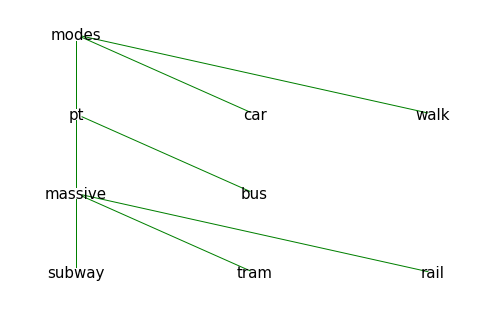

In [533]:
plot_mode_tree(sm)

In [523]:
los['route_type']

0          walk
1          walk
2           bus
3          walk
4        subway
5        subway
6        subway
7          walk
8          rail
9           bus
10       subway
11       subway
12         walk
13         rail
14          bus
15       subway
16       subway
17         walk
18         rail
19          bus
20       subway
21          bus
22         walk
23       subway
24         rail
25       subway
26       subway
27       subway
28         walk
29         rail
          ...  
70082      tram
70083    subway
70084      walk
70085      tram
70086       bus
70087      tram
70088    subway
70089    subway
70090      walk
70091      tram
70092       bus
70093      tram
70094    subway
70095      tram
70096      walk
70097    subway
70098       bus
70099    subway
70100      walk
70101       bus
70102    subway
70103      tram
70104      walk
70105    subway
70106       bus
70107      walk
70108       bus
70109      walk
70110    subway
70111      walk
Name: route_type, Length

In [183]:
%matplotlib inline
import networkx as nx

In [188]:
sm.modes = modes

In [189]:
def plot_mode_tree(self):
    g = nx.DiGraph(self.modes)
    lengths = nx.single_source_shortest_path_length(g, 'modes')
    pos = {}
    levels = [0] * (max(lengths.values()) + 1)
    for key, x in lengths.items():
        pos[key] = [levels[x],  - x]
        levels[x] += 1
    plot = nx.draw(
        g, 
        pos=pos, 
        node_color='white', 
        alpha=1, 
        node_size=100,
        arrows=False,
        edge_color='green',
        font_size=15,
        font_weight='normal',
        labels={k: k for k in g.nodes}
    )
    return plot

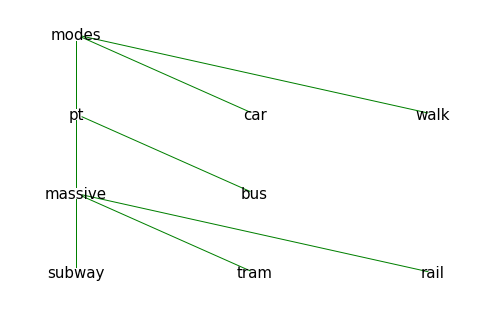

In [514]:
plot_mode_tree(sm)

In [192]:
g = nx.DiGraph(modes)
paths = nx.single_source_shortest_path(g, 'modes')
paths

{'bus': ['modes', 'pt', 'bus'],
 'car': ['modes', 'car'],
 'massive': ['modes', 'pt', 'massive'],
 'modes': ['modes'],
 'pt': ['modes', 'pt'],
 'rail': ['modes', 'pt', 'massive', 'rail'],
 'subway': ['modes', 'pt', 'massive', 'subway'],
 'tram': ['modes', 'pt', 'massive', 'tram'],
 'walk': ['modes', 'walk']}

In [321]:
level = 1
depth = max(lengths.values()) + 1
import numpy as np
def route_subtype(route_type, level):
    try:
        return  paths[route_type][level]
    except:
        return 'parent'
for level in range(1, depth):
    los['route_type_%i' % level] = los['route_type'].apply(
        lambda rt:route_subtype(route_type=rt, level=level)
    )

In [377]:
def nest_probabilities(utilities, phi=1):
    exp_sum = sum([np.exp(u/phi) for u in utilities])
    probabilities = [np.exp(u/phi) / exp_sum for u in utilities]
    return probabilities

def composite_nest_utility(utilities, phi=1):
    exp_sum = sum([np.exp(u/phi) for u in utilities])
    emu = np.log(exp_sum)
    composite_utility = phi * emu
    return composite_utility

def corrected_nest_utility(utilities, phi=1):
    composite_utility = composite_nest_utility(utilities, phi=phi)
    return composite_utility - np.log(len(utilities)) * phi

def average_nest_utility(utilities, phi=1):
    return sum(np.multiply(utilities, nest_probabilities(utilities, phi=phi)))

In [332]:
los['utility'] =  - los['gtime'] / 3600

In [333]:
groupby = los.groupby(['origin', 'destination'])

In [334]:
group = groupby.get_group(('zone_10', 'zone_20'))

In [355]:
los = los.sort_values(['origin', 'destination']).reset_index(drop=True)

In [461]:
los['route_type_4'] = los.index


In [520]:
group.set_index(['route_type_%i' % (i + 1) for i in list(range(3))]).sort_index()

alighting_links alightings  \
route_type_1 route_type_2 route_type_3                                        
pt           bus          parent                     [link_4478]       [20]   
             massive      subway         [link_14918, link_3033]  [96, 375]   
                          subway        [link_14918, link_15334]   [96, 20]   
                          subway                    [link_14357]      [253]   
walk         parent       parent                              []         []   

                                        all_walk            boarding_links  \
route_type_1 route_type_2 route_type_3                                       
pt           bus          parent           False               [link_4469]   
             massive      subway           False   [link_14914, link_3031]   
                          subway           False  [link_14914, link_15333]   
                          subway           False              [link_14353]   
walk         parent       parent            True                        []   

                                        boardings               broken_modes  \
route_type_1 route_type_2 route_type_3                                         
pt           bus          parent            [490]       {subway, rail, tram}   
             massive      subway        [490, 96]                        NaN   
                          subway        [490, 96]          {rail, tram, bus}   
                          subway            [112]                        NaN   
walk         parent       parent               []  {rail, subway, bus, tram}   

                                       broken_route destination  \
route_type_1 route_type_2 route_type_3                            
pt           bus          parent                NaN     zone_20   
             massive      subway                NaN     zone_20   
                          subway                NaN     zone_20   
                          subway            1577980     zone_20   
walk         parent       parent                NaN     zone_20   

                                                                   footpaths  \
route_type_1 route_type_2 route_type_3                                         
pt           bus          parent                                          []   
             massive      subway                                          []   
                          subway                                          []   
                          subway                     [(327, 112), (253, 20)]   
walk         parent       parent        [(399, 464), (195, 319), (319, 461)]   

                                              gtime    ...      origin  \
route_type_1 route_type_2 route_type_3                 ...               
pt           bus          parent        1797.875842    ...     zone_10   
             massive      subway        1764.716196    ...     zone_10   
                          subway        2007.875842    ...     zone_10   
                          subway        2182.498877    ...     zone_10   
walk         parent       parent        3406.957296    ...     zone_10   

                                                                                     path  \
route_type_1 route_type_2 route_type_3                                                      
pt           bus          parent        (zone_10, 490, link_4469, link_4470, link_4471...   
             massive      subway        (zone_10, 490, link_14914, link_14915, link_14...   
                          subway        (zone_10, 490, link_14914, link_14915, link_14...   
                          subway        (zone_10, 327, 112, link_14353, link_14354, li...   
walk         parent       parent        (zone_10, 399, 464, zone_14, 153, zone_13, 195...   

                                       pathfinder_session reversed  \
route_type_1 route_type_2 route_type_3                               
pt           bus          parent             

In [517]:
def build_utility_series(los, depth):
    utility_series = {}
    utility_series[depth] = los
    for l in list(reversed(range(5))):
        utility_series[l] = utility_series[l+1].groupby(
            ['origin', 'destination'] + ['route_type_%i' % (i + 1) for i in list(range(l))],
            as_index=False
        )['utility'].agg(composite_nest_utility, phi=0.5).sort_index()
    return utility_series

In [500]:
utility_series[4]

,origin,destination,route_type_1,route_type_2,route_type_3,route_type_4,utility
0,zone_0,zone_0,walk,parent,parent,0,0.000000
1,zone_0,zone_1,walk,parent,parent,1,-0.162166
2,zone_0,zone_10,pt,bus,parent,2,-0.313268
3,zone_0,zone_10,pt,massive,subway,4,-0.464878
4,zone_0,zone_10,pt,massive,subway,5,-0.502185
5,zone_0,zone_10,walk,parent,parent,3,-0.564058
6,zone_0,zone_100,pt,bus,parent,9,-0.767006
7,zone_0,zone_100,pt,massive,rail,8,-1.149200
8,zone_0,zone_100,pt,massive,subway,6,-0.523189
9,zone_0,zone_100,pt,massive,subway,10,-0.539855


In [501]:
levels = [0,  1, 2 , 3, 4]

In [502]:
for level in levels:
    us = utility_series[level]
    utility_groupby = us.groupby(
        ['origin', 'destination'] + ['route_type_%i' % (i) for i in list(range(1, level))]
    )['utility']
    flat = []
    nested = list(utility_groupby.apply(lambda s: list(s)))
    
    for l in nested:
        for i in nest_probabilities(l):
            flat.append(i)

    us['probability_%i' % level] = flat

In [503]:
level = 4

In [504]:
us = utility_series[level]
utility_groupby = us.groupby(
    ['origin', 'destination'] + ['route_type_%i' % (i) for i in list(range(1, level))]
)['utility']
flat = []
nested = list(utility_groupby.apply(lambda s: list(s)))

for l in nested:
    for i in nest_probabilities(l):
        flat.append(i)

us['probability_%i' % level] = flat

In [505]:
nested

[[0.0],
 [-0.16216625551533748],
 [-0.3132680613330181],
 [-0.46487840741819286, -0.5021850954927985],
 [-0.5640575261622467],
 [-0.7670056759654825],
 [-1.14919967681126],
 [-0.5231887519061781, -0.5398554185728448],
 [-1.4136157769423021],
 [-0.6594206902740756],
 [-1.115850775529562],
 [-0.589901925619728, -0.595742869044121],
 [-1.3121541112716526],
 [-0.6872377944416036],
 [-1.2986855510691655],
 [-0.6177594127740473, -0.6177594127740473],
 [-1.5631016512002076],
 [-0.6318200897699336],
 [-0.7861911522604528],
 [-0.6560144340431152, -0.6726811007097818, -0.7393477673764486],
 [-1.494953204818271],
 [-0.7288004445143246],
 [-1.3775339568726999],
 [-0.6530961971742066, -0.7129760351713869],
 [-1.1396863839419247, -0.7349835204550206],
 [-1.5777633055559237],
 [-0.71041513895398],
 [-0.6248393699982757, -0.7294161735618377, -0.6847192079954559],
 [-1.333801010345637],
 [-1.3836486791522113],
 [-0.6684809981225976],
 [-0.5807002042639126, -0.7308739514855804, -0.6405800422610927],
 [-

In [507]:
left = utility_series[0][['origin', 'destination']]

In [508]:
for level in [1, 2, 3, 4]:
    left = pd.merge(
        left, 
        utility_series[level], 
        on=['origin', 'destination'] + ['route_type_%i' % i for i in list(range(1, level))],
        suffixes=['', '_%i' % level]
    )

In [509]:
utility_series[4]

,origin,destination,route_type_1,route_type_2,route_type_3,route_type_4,utility,probability_4
0,zone_0,zone_0,walk,parent,parent,0,0.000000,1.000000
1,zone_0,zone_1,walk,parent,parent,1,-0.162166,1.000000
2,zone_0,zone_10,pt,bus,parent,2,-0.313268,1.000000
3,zone_0,zone_10,pt,massive,subway,4,-0.464878,0.509326
4,zone_0,zone_10,pt,massive,subway,5,-0.502185,0.490674
5,zone_0,zone_10,walk,parent,parent,3,-0.564058,1.000000
6,zone_0,zone_100,pt,bus,parent,9,-0.767006,1.000000
7,zone_0,zone_100,pt,massive,rail,8,-1.149200,1.000000
8,zone_0,zone_100,pt,massive,subway,6,-0.523189,0.504167
9,zone_0,zone_100,pt,massive,subway,10,-0.539855,0.495833


In [510]:
left['probability'] = left[['probability_%i' % (i + 1) for i in range(4)]].T.product()

In [491]:
sum(nest_probabilities([1, 2,  3,6, 5, 8]))

0.9999999999999999

In [511]:
left

,origin,destination,route_type_1,utility,probability_1,route_type_2,utility_2,probability_2,route_type_3,utility_3,probability_3,route_type_4,utility_4,probability_4,probability
0,zone_0,zone_0,walk,0.000000,1.000000,parent,0.000000,1.000000,parent,0.000000,1.000000,0,0.000000,1.000000,1.000000
1,zone_0,zone_1,walk,-0.162166,1.000000,parent,-0.162166,1.000000,parent,-0.162166,1.000000,1,-0.162166,1.000000,1.000000
2,zone_0,zone_10,pt,0.129396,0.666735,bus,-0.313268,0.455950,parent,-0.313268,1.000000,2,-0.313268,1.000000,0.303998
3,zone_0,zone_10,pt,0.129396,0.666735,massive,-0.136610,0.544050,subway,-0.136610,1.000000,4,-0.464878,0.509326,0.184751
4,zone_0,zone_10,pt,0.129396,0.666735,massive,-0.136610,0.544050,subway,-0.136610,1.000000,5,-0.502185,0.490674,0.177986
5,zone_0,zone_10,walk,-0.564058,0.333265,parent,-0.564058,1.000000,parent,-0.564058,1.000000,3,-0.564058,1.000000,0.333265
6,zone_0,zone_100,pt,0.003483,0.804883,bus,-0.767006,0.342994,parent,-0.767006,1.000000,9,-0.767006,1.000000,0.276070
7,zone_0,zone_100,pt,0.003483,0.804883,massive,-0.117026,0.657006,rail,-1.149200,0.276014,8,-1.149200,1.000000,0.145960
8,zone_0,zone_100,pt,0.003483,0.804883,massive,-0.117026,0.657006,subway,-0.184879,0.723986,6,-0.523189,0.504167,0.193022
9,zone_0,zone_100,pt,0.003483,0.804883,massive,-0.117026,0.657006,subway,-0.184879,0.723986,10,-0.539855,0.495833,0.189831


In [513]:
left.set_index(['origin', 'destination', 'route'])

,origin,destination,route_type_1,utility,probability_1,route_type_2,utility_2,probability_2,route_type_3,utility_3,probability_3,route_type_4,utility_4,probability_4,probability
0,zone_0,zone_0,walk,0.000000,1.000000,parent,0.000000,1.000000,parent,0.000000,1.000000,0,0.000000,1.000000,1.000000
1,zone_0,zone_1,walk,-0.162166,1.000000,parent,-0.162166,1.000000,parent,-0.162166,1.000000,1,-0.162166,1.000000,1.000000
2,zone_0,zone_10,pt,0.129396,0.666735,bus,-0.313268,0.455950,parent,-0.313268,1.000000,2,-0.313268,1.000000,0.303998
3,zone_0,zone_10,pt,0.129396,0.666735,massive,-0.136610,0.544050,subway,-0.136610,1.000000,4,-0.464878,0.509326,0.184751
4,zone_0,zone_10,pt,0.129396,0.666735,massive,-0.136610,0.544050,subway,-0.136610,1.000000,5,-0.502185,0.490674,0.177986
5,zone_0,zone_10,walk,-0.564058,0.333265,parent,-0.564058,1.000000,parent,-0.564058,1.000000,3,-0.564058,1.000000,0.333265
6,zone_0,zone_100,pt,0.003483,0.804883,bus,-0.767006,0.342994,parent,-0.767006,1.000000,9,-0.767006,1.000000,0.276070
7,zone_0,zone_100,pt,0.003483,0.804883,massive,-0.117026,0.657006,rail,-1.149200,0.276014,8,-1.149200,1.000000,0.145960
8,zone_0,zone_100,pt,0.003483,0.804883,massive,-0.117026,0.657006,subway,-0.184879,0.723986,6,-0.523189,0.504167,0.193022
9,zone_0,zone_100,pt,0.003483,0.804883,massive,-0.117026,0.657006,subway,-0.184879,0.723986,10,-0.539855,0.495833,0.189831


In [399]:
us = utility_series[3]
utility_groupby = us.groupby(['origin', 'destination'])['utility']
flat = []
nested = list(utility_groupby.apply(lambda s: list(s)))
for l in nested:
    for i in l:
        flat.append(i)

us['probability'] = flat

In [387]:

#.apply(nest_probabilities)

origin   destination
zone_0   zone_0                                                 [0.0]
         zone_1                                [-0.16216625551533748]
         zone_10           [0.12939615777705143, -0.5640575261622467]
         zone_100        [0.0034826886015797637, -1.4136157769423021]
         zone_101        [-0.007100563432721711, -1.3121541112716526]
         zone_102        [-0.047810090655244795, -1.5631016512002076]
         zone_103           [0.11070176477112773, -1.494953204818271]
         zone_104          [0.06543045081015969, -1.5777633055559237]
         zone_105         [0.040460881075396256, -1.3836486791522113]
         zone_106          [0.04089850209103082, -1.1683758088073544]
         zone_107          [0.03713306211021047, -1.6583685174905969]
         zone_108          [0.12643916501757962, -1.5915252800329043]
         zone_109           [0.1792412231158105, -1.5777858083879983]
         zone_11                               [-0.19284018002382342]

In [341]:
group.groupby(
    ['route_type_%i' %i for i in [1, 2, 3]],
    as_index=False
)['utility'].agg(composite_nest_utility, phi=0.5)

,route_type_1,route_type_2,route_type_3,utility
0,pt,bus,parent,-0.499410
1,pt,massive,subway,0.000185
2,walk,parent,parent,-0.946377


In [311]:
groups = groupby.get_group().values()

AttributeError: 'function' object has no attribute 'values'

In [307]:
average_nest_utility([3, 2, 3]), nest_utility([3, 2, 3])

(2.8446375965030364, 2.7633825153901412)

In [288]:
phi = 0.5
nest_utilities([5.5, 6]*20, phi=phi) - np.log(20)*phi

4452578.662684036 15.308993961072215 7.654496980536107


6.156630843759112

In [286]:
np.

0.34657359027997264

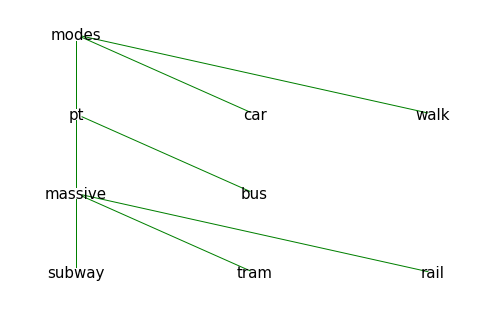

In [259]:
plot_mode_tree(sm)

In [144]:
help(nx.draw_networkx)

Help on function draw_networkx in module networkx.drawing.nx_pylab:

draw_networkx(G, pos=None, arrows=True, with_labels=True, **kwds)
    Draw the graph G using Matplotlib.
    
    Draw the graph with Matplotlib with options for node positions,
    labeling, titles, and many other drawing features.
    See draw() for simple drawing without labels or axes.
    
    Parameters
    ----------
    G : graph
       A networkx graph
    
    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See :py:mod:`networkx.drawing.layout` for functions that
       compute node positions.
    
    arrows : bool, optional (default=True)
       For directed graphs, if True draw arrowheads.
    
    with_labels :  bool, optional (default=True)
       Set to True to draw labels on the nodes.
    
    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib ax

In [121]:
levels = [0] * (max(lengths.values() )+ 1)

TypeError: unsupported operand type(s) for +: 'dict_values' and 'int'

In [120]:
levels

[0, 0, 0]

In [70]:
digraph mon_graphe {
     a -> b -> c;
     b -> d;
 }

SyntaxError: invalid syntax (<ipython-input-70-19675a644de7>, line 1)

In [65]:
los['route_type']

0         walk
1         walk
2         walk
3         walk
4         walk
5       subway
6          bus
7          bus
8       subway
9          bus
10      subway
11         bus
12        rail
13         bus
14      subway
15         bus
16         bus
17         bus
18        rail
19      subway
20      subway
21      subway
22      subway
23         bus
24         bus
25      subway
26      subway
27      subway
28      subway
29         bus
         ...  
1744    subway
1755    subway
1757    subway
1940    subway
1967    subway
2044    subway
2142    subway
2154    subway
2159    subway
2188    subway
2297    subway
2301    subway
310       tram
930     subway
986     subway
989       tram
1085      tram
1421    subway
1481      tram
2034    subway
2041    subway
2053    subway
2063    subway
2065    subway
2082    subway
2084    subway
2088    subway
2089      tram
2195    subway
2292      tram
Name: route_type, Length: 70112, dtype: object

In [26]:
los['link_path']

0                                                      []
1                                                      []
2                                                      []
3                                                      []
4                                                      []
5                    [link_15476, link_15477, link_15478]
6                                  [link_1929, link_1931]
7        [link_13296, link_13295, link_13297, link_13298]
8        [link_15371, link_15372, link_15373, link_15374]
9                    [link_13296, link_13295, link_13297]
10                               [link_15476, link_15477]
11       [link_10436, link_10435, link_10437, link_10438]
12                                 [link_9409, link_9410]
13                                 [link_1635, link_1636]
14      [link_15448, link_15449, link_15450, link_1545...
15      [link_1787, link_1788, link_1789, link_1790, l...
16                   [link_21687, link_21688, link_21689]
17      [link_